In [190]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler


# Questions for Professor:
* Batch Size... I have 1826 rows in total... It is set to 20?
* There is no "accuracy" because of the regression and that the results are integers sales?
* The Loss is extremly low... WHy would this be the case?
* I'm not sure I understand the concept of the sequence length
* On the `forward` method of the model I use:
  ```
    h0 = torch.zeros(num_layers, y.size(0), hidden_size).to(y.device)
    c0 = torch.zeros(num_layers, y.size(0), hidden_size).to(y.device)
  ```
* I somehow had a hard time creating the LSTM network and then adding it to the model.. Will need to work on that some but is it ok?
* ~How would I try to "un-scale" the values to plot the prediction vs. the validation values?~
* Is dropout a good idea?
* I used "4" for the stacked LSTM layers... is that overkill and should I just stay with "1"?
* Overall... is the the right approach for this project? It seems a bit general and I havent really contributed to anything meaninful...

In [283]:
# Config & Setup Details
cfg_batch_size  = 100
cfg_max_epochs  = 50
cfg_num_workers = 2

# Learning Config
cfg_split        = 0.8
cfg_sequence_len = 90

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [284]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [285]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

df_grouped_date_store = df_raw.groupby(['date', 'store'])['sales'].sum().reset_index()
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()

print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("********\n")

print(f"Grouped by Date & Store Shape: {df_grouped_date_store.shape}")
print(df_grouped_date_store)
print("********\n")

# Pivot the DataFrame
df_train = df_grouped_date_store.pivot(index='date', columns='store', values='sales')

# Resetting the index
df_train = df_train.reset_index()

# Show the New Table
print(f"Training Shape: {df_train.shape}")
print(df_train)
print(f"Training Cols: {df_train.columns}")
print("********\n")



Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]
********

Grouped by Date & Store Shape: (18260, 3)
            date  store  sales
0     2013-01-01      1   1316
1     2013-01-01      2   1742
2     2013-01-01      3   1588
3     2013-01-01      4   1423
4     2013-01-01      5   1032
...          ...    ...    ...
18255 2017-12-31      6   2009
18256 2017-12-31      7   1831
18257 2017-12-31      8   3205
18258 2017-12-31      9   2774
18259 2017-12-31     10   2939

[18260 row

In [286]:
# Setup the Dataframe being used
df = df_train # Simple Copy
df.set_index('date', inplace=True)
print(f"DF Shape: {df.shape}")

DF Shape: (1826, 10)


In [287]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Create sequences
x, y = create_sequences(df.values, cfg_sequence_len)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
train_size = int(cfg_split * len(x_tensor))

x_train = x_tensor[:train_size]
y_train = y_tensor[:train_size]

x_val = x_tensor[train_size:]
y_val = y_tensor[train_size:]

In [288]:
print(f"x Shape: {x.shape}")
print(f"y Shape: {y.shape}")
print("")
print(f"x_train Shape: {x_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print("")
print(f"x_val Shape: {x_val.shape}")
print(f"y_val Shape: {y_val.shape}")

x Shape: (1736, 90, 10)
y Shape: (1736, 10)

x_train Shape: torch.Size([1388, 90, 10])
y_train Shape: torch.Size([1388, 10])

x_val Shape: torch.Size([348, 90, 10])
y_val Shape: torch.Size([348, 10])


In [299]:
class LSTMModel(pl.LightningModule):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 num_layers,
                 scaler = 1000,
                 **kwargs):
        super().__init__(**kwargs)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.scaler = scaler

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    # No complications with regression...
    def predict(self, x):
        return self(x)
    
    def forward(self, x):
        y = x 
        y = y / self.scaler
        y, _ = self.lstm(y)
        y = y[:, -1, :] # Extract only the last time step
        y = self.linear(y) # Using linear to bring back to output_size
        y = self.dropout(y)  # Dropout after linear layer
        y = y * self.scaler
        
        return y

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss


# Model parameters
input_size  = 10 # Number of features (sales data from 10 stores)
hidden_size = 50 # Number of features in hidden state
output_size = 10 # Number of output values (future sales prediction)
num_layers  = 4  # Number of stacked LSTM layers

# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [300]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [5, 10]                   --
├─LSTM: 1-1                              [5, 90, 50]               73,600
├─Linear: 1-2                            [5, 10]                   510
├─Dropout1d: 1-3                         [5, 10]                   --
Total params: 74,110
Trainable params: 74,110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 33.12
Input size (MB): 6.25
Forward/backward pass size (MB): 0.18
Params size (MB): 0.30
Estimated Total Size (MB): 6.73

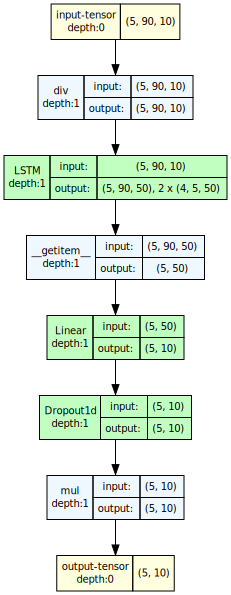

In [301]:
model_graph = draw_graph(model,
                         input_data=torch.Tensor(x_train[0:5]).float(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [302]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val).float(), 
                                              torch.Tensor(y_val).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)

In [303]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Project",
                              version="1.0.0")

In [304]:
trainer = pl.Trainer(logger=logger, max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [305]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lightning_logs/Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │         9697272.0         │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 9697272.0}]

In [306]:
trainer.fit(model, xy_train, xy_val) 


  | Name    | Type      | Params
--------------------------------------
0 | lstm    | LSTM      | 73.6 K
1 | dropout | Dropout1d | 0     
2 | linear  | Linear    | 510   
3 | loss    | MSELoss   | 0     
--------------------------------------
74.1 K    Trainable params
0         Non-trainable params
74.1 K    Total params
0.296     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [297]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_loss,epoch,step,train_loss
0,9.680909e+06,0,0,NaN
1,9.631245e+06,0,13,NaN
2,NaN,0,13,7244172.00
3,9.556022e+06,1,27,NaN
4,NaN,1,27,7193257.00
...,...,...,...,...
96,NaN,47,671,1039305.50
97,8.746802e+05,48,685,NaN
98,NaN,48,685,965698.75
99,8.746751e+05,49,699,NaN


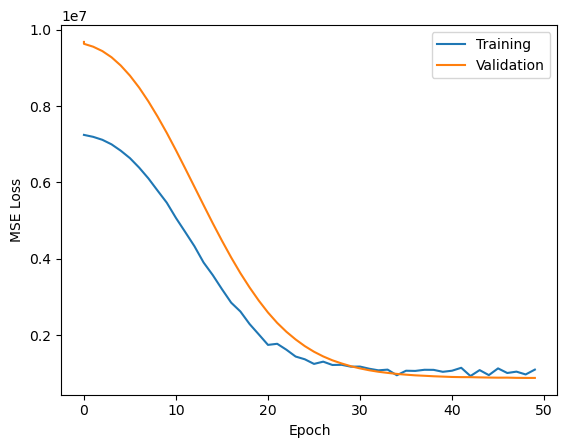

In [298]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("MSE Loss") 
plt.xlabel("Epoch") 
plt.show()

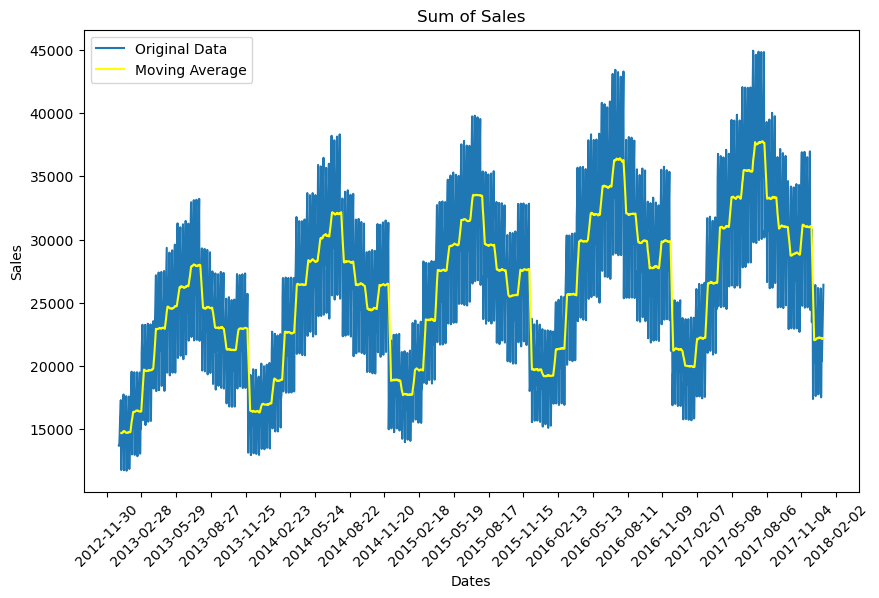

In [188]:
# Lets me crop the data to look at it
df_plot_data = df[:]

# Assuming df's index is the date and the rest of the columns are integers
summed_values = df_plot_data.sum(axis=1)

# Compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 7  # Two Weeks
moving_avg_values = moving_average(summed_values, window_size)

# Adjust dates for moving average (since convolution 'valid' reduces the length)
adjusted_dates_for_moving_avg = df_plot_data.index[window_size - 1:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_plot_data.index, summed_values, label='Original Data')
plt.plot(adjusted_dates_for_moving_avg, moving_avg_values, color='yellow', label='Moving Average')

plt.xlabel('Dates')
plt.ylabel('Sales')
plt.title('Sum of Sales')
plt.xticks(rotation=45)

# Formatting date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90)) # 3months

plt.legend()
plt.show()

In [62]:
# Assuming single_data_point is your input with shape [seq_len, input_size]
# Make sure it's a 2D array with seq_len rows and input_size columns
single_data_point = [[1000, 1000, 1000, 1000, 1000, 100]]

# Convert to a PyTorch tensor and add a batch dimension
# New shape: [1, seq_len, input_size]
tensor_input = torch.tensor(single_data_point, dtype=torch.float32).unsqueeze(0)

# Now you can pass tensor_input to your model
predicted_output = model.predict(tensor_input)

# The output will be a tensor. To convert it to a numpy array or a list, you can do:
predicted_output = predicted_output.detach().numpy()  # If y

predicted_output

array([[ 0.08835854,  0.03541141, -0.03749266,  0.15458779,  0.09290537,
         0.1695647 , -0.02830181, -0.05998186, -0.01466712,  0.00023635]],
      dtype=float32)

In [282]:
single_data_point = [[1316,  1742,  1588,  1423,  1032,  1099,   964,  1628,  1383,  1521], [1316,  1742,  1588,  1423,  1032,  1099,   964,  1628,  1383,  1521], [1316,  1742,  1588,  1423,  1032,  1099,   964,  1628,  1383,  1521]]

# Convert to a PyTorch tensor and add a batch dimension
# New shape: [1, seq_len, input_size]
tensor_input = torch.tensor(single_data_point, dtype=torch.float32).unsqueeze(0)

# Now you can pass tensor_input to your model
predicted_output = model.predict(tensor_input)

# The output will be a tensor. To convert it to a numpy array or a list, you can do:
predicted_output = predicted_output.detach().numpy()  # If y

predicted_output

array([[2311.9978, 3250.0972, 2906.4907, 2685.379 , 1944.2347, 1942.1125,
        1777.42  , 3120.7148, 2691.9639, 2869.093 ]], dtype=float32)

In [72]:
df

store,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2013-01-01,1316,1742,1588,1423,1032,1099,964,1628,1383,1521
2013-01-02,1264,1808,1538,1432,997,1023,944,1687,1455,1530
2013-01-03,1305,1887,1635,1534,1130,1149,966,1736,1492,1654
2013-01-04,1452,1983,1741,1685,1258,1201,1040,1966,1612,1739
2013-01-05,1499,2087,1887,1649,1154,1286,1131,2005,1698,1841
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1837,2624,2365,2176,1552,1560,1471,2468,2104,2221
2017-12-28,1951,2839,2479,2306,1696,1707,1509,2660,2309,2429
2017-12-29,2116,3025,2646,2460,1774,1737,1689,2923,2478,2687


In [69]:
df_scaled[0]

array([0.09538751, 0.05664287, 0.07105943, 0.05176337, 0.06720122,
       0.09610291, 0.07228916, 0.05164434, 0.05189456, 0.0610427 ])

In [80]:
out = scaler.inverse_transform(df_scaled[0:1])
df_unscaled = pd.DataFrame(out, columns=df.columns)

In [81]:
out

array([[1316., 1742., 1588., 1423., 1032., 1099.,  964., 1628., 1383.,
        1521.]])

In [82]:
df_unscaled

store,1,2,3,4,5,6,7,8,9,10
0,1316.0,1742.0,1588.0,1423.0,1032.0,1099.0,964.0,1628.0,1383.0,1521.0


In [87]:
df[0:1].shape

(1, 10)

In [88]:
df

store,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2013-01-01,1316,1742,1588,1423,1032,1099,964,1628,1383,1521
2013-01-02,1264,1808,1538,1432,997,1023,944,1687,1455,1530
2013-01-03,1305,1887,1635,1534,1130,1149,966,1736,1492,1654
2013-01-04,1452,1983,1741,1685,1258,1201,1040,1966,1612,1739
2013-01-05,1499,2087,1887,1649,1154,1286,1131,2005,1698,1841
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1837,2624,2365,2176,1552,1560,1471,2468,2104,2221
2017-12-28,1951,2839,2479,2306,1696,1707,1509,2660,2309,2429
2017-12-29,2116,3025,2646,2460,1774,1737,1689,2923,2478,2687
